In [2]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [5]:
cd 'gdrive/My Drive/Colab Notebooks/'

/content/gdrive/My Drive/Colab Notebooks


In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = (BATCH_SIZE)
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
num_of_classes = len(class_names)
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset) ## It means 68 Batches of 32 Images

68

In [10]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())
  


(32, 256, 256, 3)
[1 1 1 1 0 0 2 1 0 0 1 0 1 0 1 2 2 0 0 0 1 0 1 1 0 1 1 2 0 1 0 0]


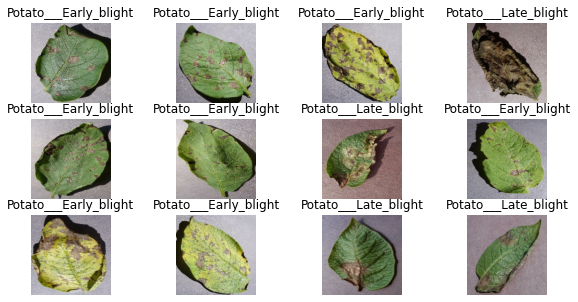

In [11]:
plt.figure(figsize=(10,5))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.axis("off")
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])

  # Train test split
  ### 80% ---> training data
  ### 20% ---> 10% validation,10% test

In [12]:
len(dataset)

68

In [13]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [14]:
#Train data
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
# Test data
test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:
validation_size = 0.1
len(dataset) * validation_size

6.800000000000001

In [17]:
validation_ds = test_ds.take(6)
test_ds = test_ds.skip(6)

In [18]:
def get_dataset_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)


  train_size = int(train_split*ds_size)
  train_ds = dataset.take(train_size)

  val_size = int(len(dataset)*test_split)

  val_ds = dataset.skip(train_size).take(val_size)
  test_ds = dataset.skip(train_size).skip(val_size)
  
  return train_ds , test_ds, val_ds

In [19]:
train_ds, test_ds,val_ds = get_dataset_partition(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(test_ds)

8

In [22]:
len(val_ds)

6

## Using prefect and chaching to optimize to time 

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# Image Preprocessing

#### Scaling pipeLine

In [24]:
resize_and_scale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

#### Data Augmentation for robustness of the model

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# CNN Model Buidling 

In [26]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

In [27]:
model = models.Sequential([
    resize_and_scale,
    data_augmentation,
    
    #ConvolutionLayers
    layers.Conv2D(35,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=37,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(25,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(75,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),

    #FLattenLayers
    layers.Flatten(),

    #DenseLayers
    layers.Dense(64,activation='relu'),
    layers.Dense(num_of_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 35)        980       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 35)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 37)        11692     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 37)         0         
 2D)                                                  

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [30]:
history = model.fit(train_ds,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose = 1,
          validation_data = val_ds
          )

Epoch 1/50
54/54 [==============================] - 257s 518ms/step - loss: 0.9218 - accuracy: 0.4647 - val_loss: 0.9092 - val_accuracy: 0.4427
Epoch 2/50
54/54 [==============================] - 4s 74ms/step - loss: 0.7605 - accuracy: 0.6204 - val_loss: 0.5337 - val_accuracy: 0.7448
Epoch 3/50
54/54 [==============================] - 4s 73ms/step - loss: 0.4249 - accuracy: 0.8235 - val_loss: 0.2517 - val_accuracy: 0.9219
Epoch 4/50
54/54 [==============================] - 4s 73ms/step - loss: 0.3324 - accuracy: 0.8715 - val_loss: 0.2518 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 4s 73ms/step - loss: 0.3026 - accuracy: 0.8814 - val_loss: 0.5167 - val_accuracy: 0.7604
Epoch 6/50
54/54 [==============================] - 4s 73ms/step - loss: 0.3064 - accuracy: 0.8733 - val_loss: 0.2237 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 4s 73ms/step - loss: 0.2802 - accuracy: 0.8877 - val_loss: 0.2918 - val_accuracy: 0.8698
Epoch 8/50

In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 4s 55ms/step - loss: 0.0689 - accuracy: 0.9828


In [32]:
scores

[0.06891334801912308, 0.982758641242981]

In [33]:
history

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### Plotting the history of model

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss  = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation losses')

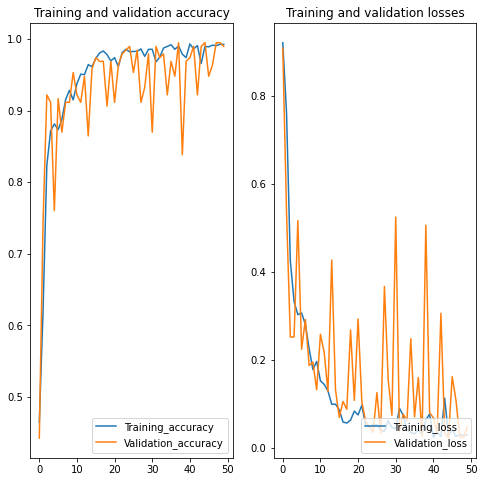

In [37]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training_accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation_accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training_loss')
plt.plot(range(EPOCHS),val_loss,label='Validation_loss')
plt.legend(loc='lower right')
plt.title('Training and validation losses')

#### Prediction

First Image to Predict

actual label :  Potato___Late_blight
predicted label : Potato___Late_blight


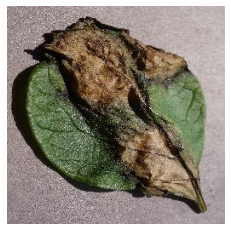

In [38]:
for image_batch,label_batch in test_ds.take(1):
  first_img = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()

  print('First Image to Predict\n')
  plt.axis('off')
  plt.imshow(first_img)
  print('actual label : ',class_names[first_label])

  predicted_batch = model.predict(image_batch)
  print('predicted label :',class_names[np.argmax(predicted_batch[0])])

In [39]:
def predicted(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100* np.max(predictions[0]),2)

  return predicted_class,confidence 

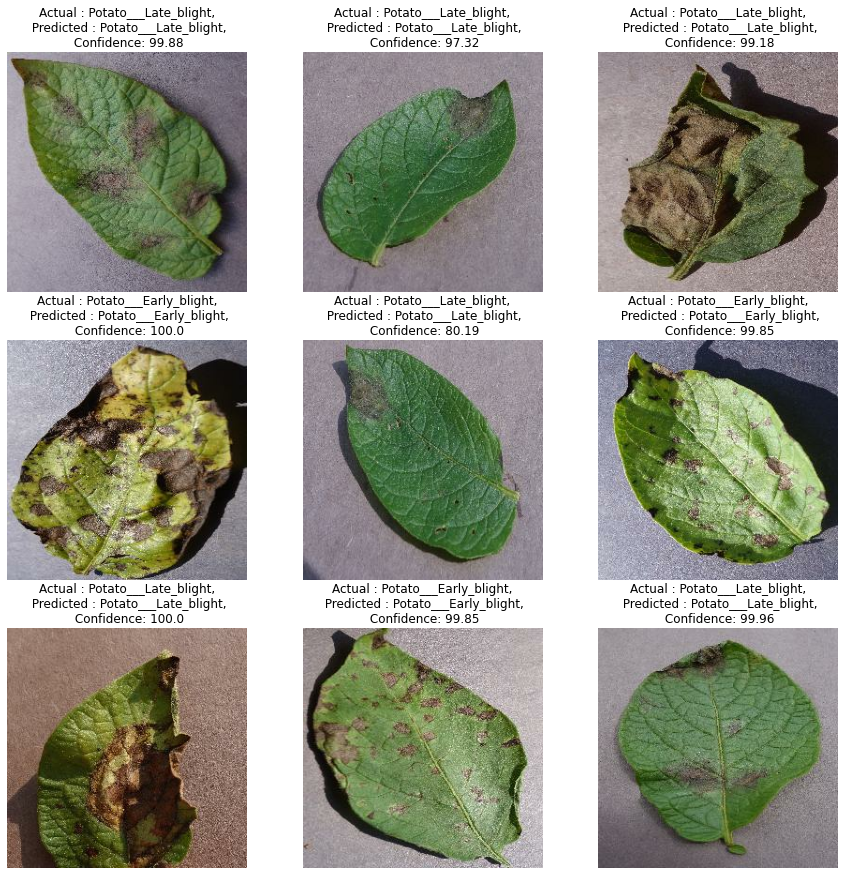

In [41]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.imshow(images[i].numpy().astype('uint8'))
    
    predicted_class,confidence = predicted(model,images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f'Actual : {actual_class},\n Predicted : {predicted_class},\n Confidence: {confidence}')

## Exporting the Model

In [42]:
model_version = 1
model.save(f'../models/{model_version}') 

In [44]:
pwd

'/content/gdrive/MyDrive/Colab Notebooks'